In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
from data.pre_process_ecg_utils import leads

sys.path.append(os.path.abspath(".."))
import models_mae

torch.manual_seed(42)

/home/abujalancegome/.conda/envs/mae3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
TRAIN_DIR="/projects/prjs1252/CL_data/ECG_data/ECG_balanced_train_leads.pt"

tensor = torch.load(TRAIN_DIR)

print(tensor.shape)
print(tensor.dtype)

torch.Size([10366, 1, 12, 5000])
torch.float32


In [5]:
tensor = tensor.squeeze(2).unsqueeze(1)

print(tensor.shape)
print(tensor.dtype)

torch.Size([10366, 1, 12, 5000])
torch.float32


In [7]:
torch.save(tensor, TRAIN_DIR)

In [11]:
VAL_DIR="/projects/prjs1252/CL_data/ECG_data/ECG_leads_val"

tensor = torch.load(VAL_DIR)

print(tensor.shape)
print(tensor.dtype)


torch.Size([10183, 1, 12, 5000])
torch.float32


In [3]:
ECG_TRAIN_DIR='/projects/prjs1252/CL_data/CL_ECG_leads_train.pt'

tensor = torch.load(ECG_TRAIN_DIR)

print(tensor.shape)
print(tensor.dtype)

torch.Size([23940, 1, 12, 5000])
torch.float32


In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

## Comparison between original Signal and DeNoised Signal

In [9]:
tensor_path = "/home/abujalancegome/deep_risk/data/full_data_ECGs_w_IDs.pth"
tensor_path = "/home/abujalancegome/deep_risk/data/full_data_ECGs_w_IDs_50_test_or.pth" # for testing ECG pre-processed
tensor_path = "/home/abujalancegome/deep_risk/data/ECG_leads_full_pretraining_w_IDs_50.pth" # for testing ECG pre-processed


print(torch.load(tensor_path).keys())

original_main_tensor = torch.load(tensor_path)["ECG_originals"].to(dtype=torch.float32)

main_tensor = torch.load(tensor_path)["ECG_tensors"].to(dtype=torch.float32)

id_tensor = torch.load(tensor_path)["IDs"]

print(main_tensor.shape)
#tensor = tensor[10:20,:,:]
print(main_tensor.shape)

dict_keys(['ECG_tensors', 'ECG_originals', 'IDs'])
torch.Size([200, 12, 5000])
torch.Size([200, 12, 5000])


In [4]:
print(id_tensor)

['3079203', '2384941', '4776413', '5081031', '4483466', '5696622', '4628879', '4203267', '3918276', '2327572', '1007640', '1478294', '2506917', '2982397', '2240482', '4602388', '4190733', '5643881', '5276454', '1756726', '1951987', '5902911', '2059065', '2501297', '4017706', '5053492', '5690952', '1656775', '2406994', '3883578', '2398343', '5653904', '1039933', '2632673', '5929978', '3456466', '4904034', '1840170', '4956562', '3939359', '4791571', '1962201', '5132786', '5313084', '3133401', '2491697', '2404549', '5314610', '2422445', '1240306', '1829892', '3970315', '1546317', '2769313', '2543676', '2458660', '3376074', '1018347', '2477477', '2678322', '3064007', '4906498', '3483642', '2307305', '1075257', '4858446', '4144747', '5218192', '2089609', '4666540', '2376060', '4134881', '5049343', '3411885', '1273827', '4029872', '4382061', '1062962', '4142033', '5207528', '4829633', '3365295', '1165338', '1206922', '1733404', '1986145', '3668099', '1053935', '2588663', '5770827', '2216631'

In [7]:
print(id_tensor)

['5312725', '1245643', '5996672', '5966873', '1074932', '1372022', '4025132', '2719963', '3705736', '4908834', '1127005', '1316328', '1937209', '5152728', '4063715', '1114873', '5212789', '1621042', '1105474', '1278465', '1055252', '5118763', '3074814', '4559395', '4233823', '2072100', '2657223', '3874353', '1041575', '2125318', '5409416', '1603138', '5897248', '3136479', '5182458', '1515685', '1675721', '2351182', '3205770', '5031257', '2604143', '5972595', '4558247', '4498273', '4610696', '5614631', '5993167', '1719555', '1054693', '1974999', '5930739', '1282182', '4254615', '1495163', '5778933', '5641312', '2547939', '4214932', '4620441', '4095092', '5162711', '3467662', '4157775', '5888425', '3458115', '3068858', '3455045', '1888803', '5117528', '5090795', '3111226', '2478569', '2520145', '5467289', '2630530', '3322104', '5035844', '2890853', '2651309', '4587593', '5763099', '3390435', '1977340', '1977855', '4318536', '3924301', '5757261', '2160521', '1852526', '1980238', '1249263'

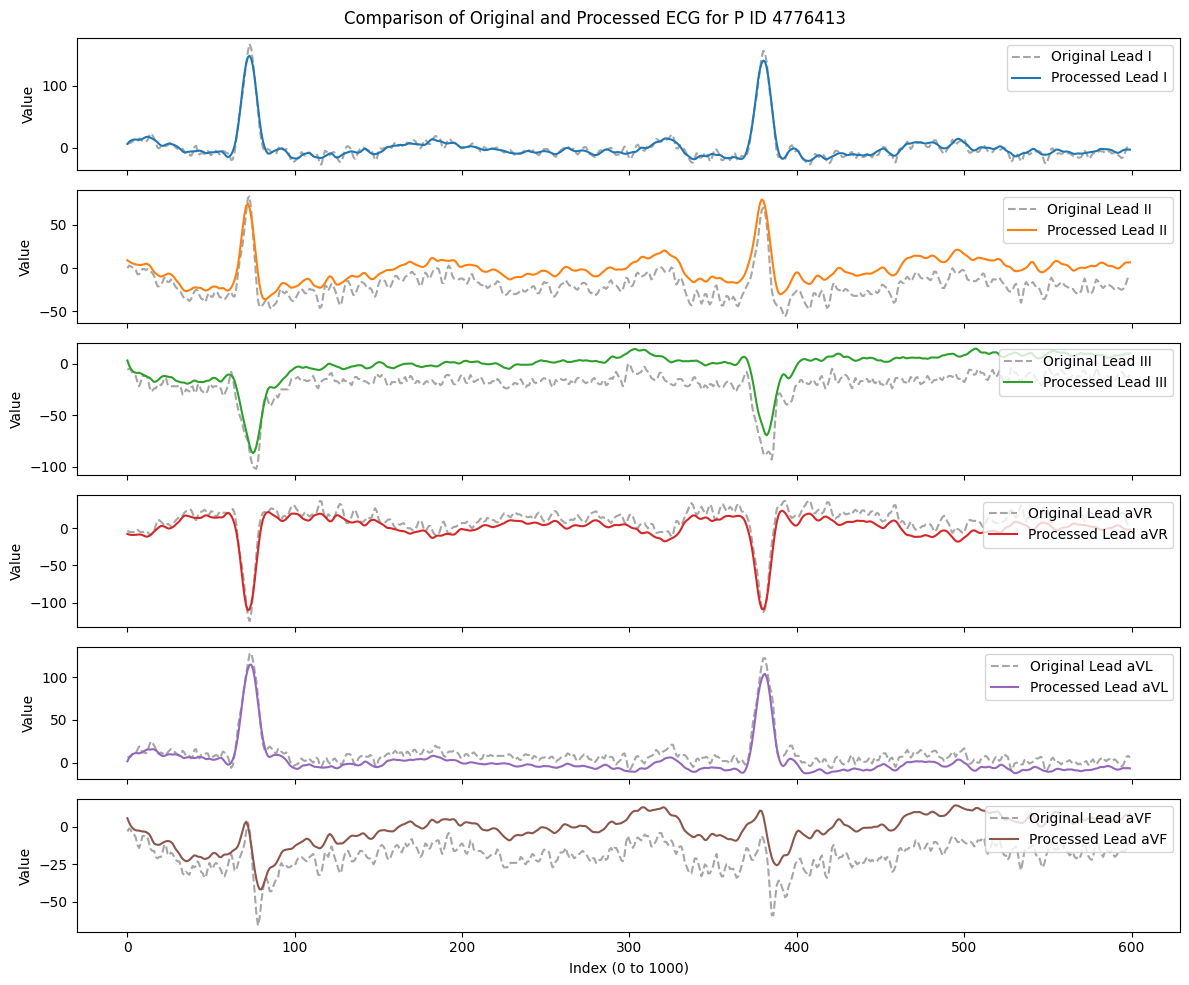

In [10]:
# Extract the original and processed ECG signals
tensor_idx = 2
original_tensor = original_main_tensor[tensor_idx, :, :600]  # Assuming you have the original data
processed_tensor = main_tensor[tensor_idx, :, :600]  # Processed ECG

# Create subplots
leads_2_plot = 6
fig, axes = plt.subplots(nrows=leads_2_plot, ncols=1, figsize=(12, 10), sharex=True)

for i in range(leads_2_plot):
    # Plot original ECG in gray
    axes[i].plot(original_tensor[i].numpy(), label=f"Original Lead {leads[i]}", color="gray", linestyle="dashed", alpha=0.7)

    # Plot processed ECG in color
    axes[i].plot(processed_tensor[i].numpy(), label=f"Processed Lead {leads[i]}", color=f"C{i}")

    # Add legend and labels
    axes[i].legend(loc="upper right")
    axes[i].set_ylabel("Value")

axes[-1].set_xlabel("Index (0 to 1000)")
fig.suptitle(f"Comparison of Original and Processed ECG for P ID {id_tensor[tensor_idx]}", fontsize=12)

plt.tight_layout()
plt.show()

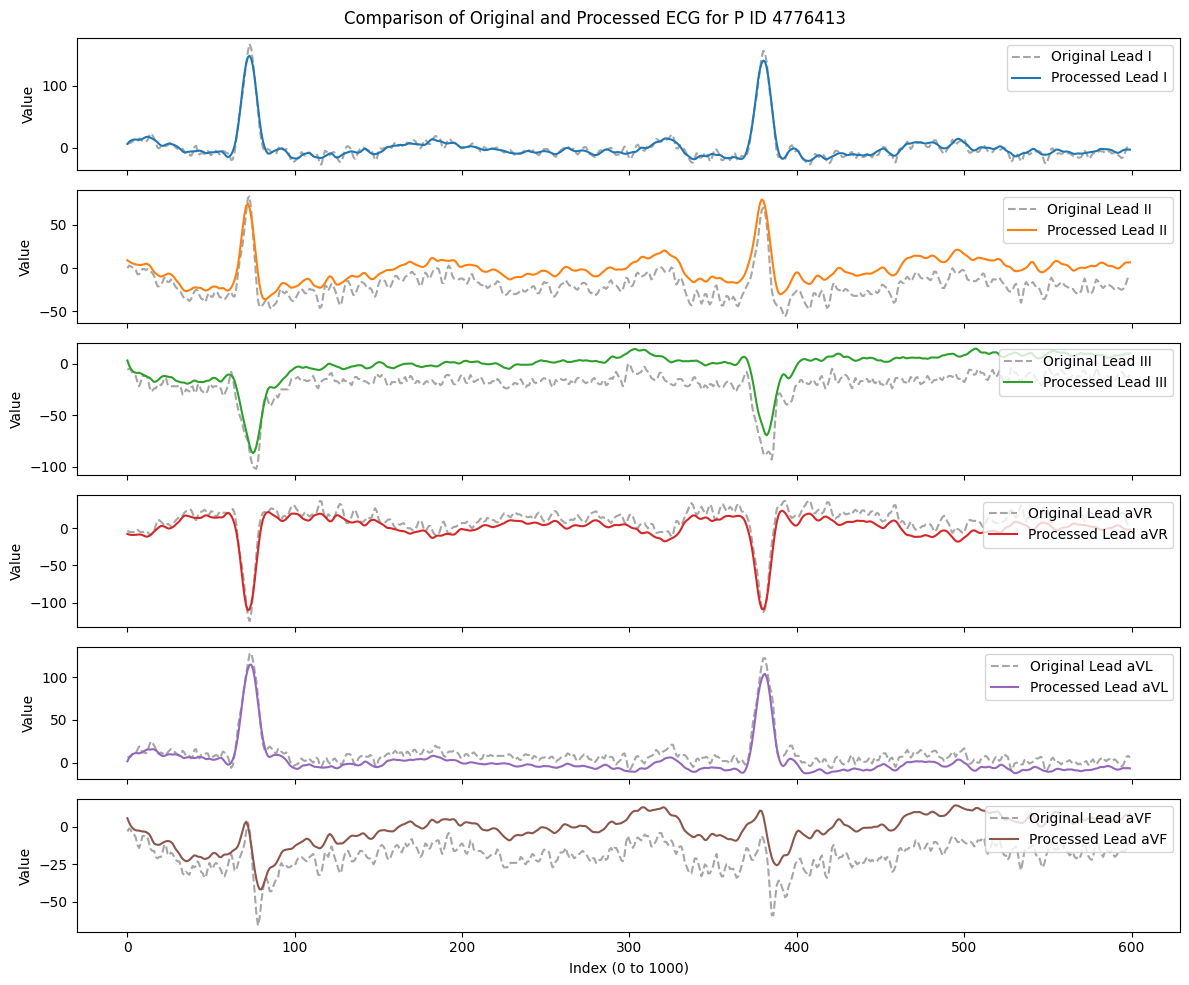

In [11]:
# Extract the original and processed ECG signals
tensor_idx = 2
original_tensor = original_main_tensor[tensor_idx, :, :600]  # Assuming you have the original data
processed_tensor = main_tensor[tensor_idx, :, :600]  # Processed ECG

# Create subplots
leads_2_plot = 6
fig, axes = plt.subplots(nrows=leads_2_plot, ncols=1, figsize=(12, 10), sharex=True)

for i in range(leads_2_plot):
    # Plot original ECG in gray
    axes[i].plot(original_tensor[i].numpy(), label=f"Original Lead {leads[i]}", color="gray", linestyle="dashed", alpha=0.7)

    # Plot processed ECG in color
    axes[i].plot(processed_tensor[i].numpy(), label=f"Processed Lead {leads[i]}", color=f"C{i}")

    # Add legend and labels
    axes[i].legend(loc="upper right")
    axes[i].set_ylabel("Value")

axes[-1].set_xlabel("Index (0 to 1000)")
fig.suptitle(f"Comparison of Original and Processed ECG for P ID {id_tensor[tensor_idx]}", fontsize=12)

plt.tight_layout()
plt.show()


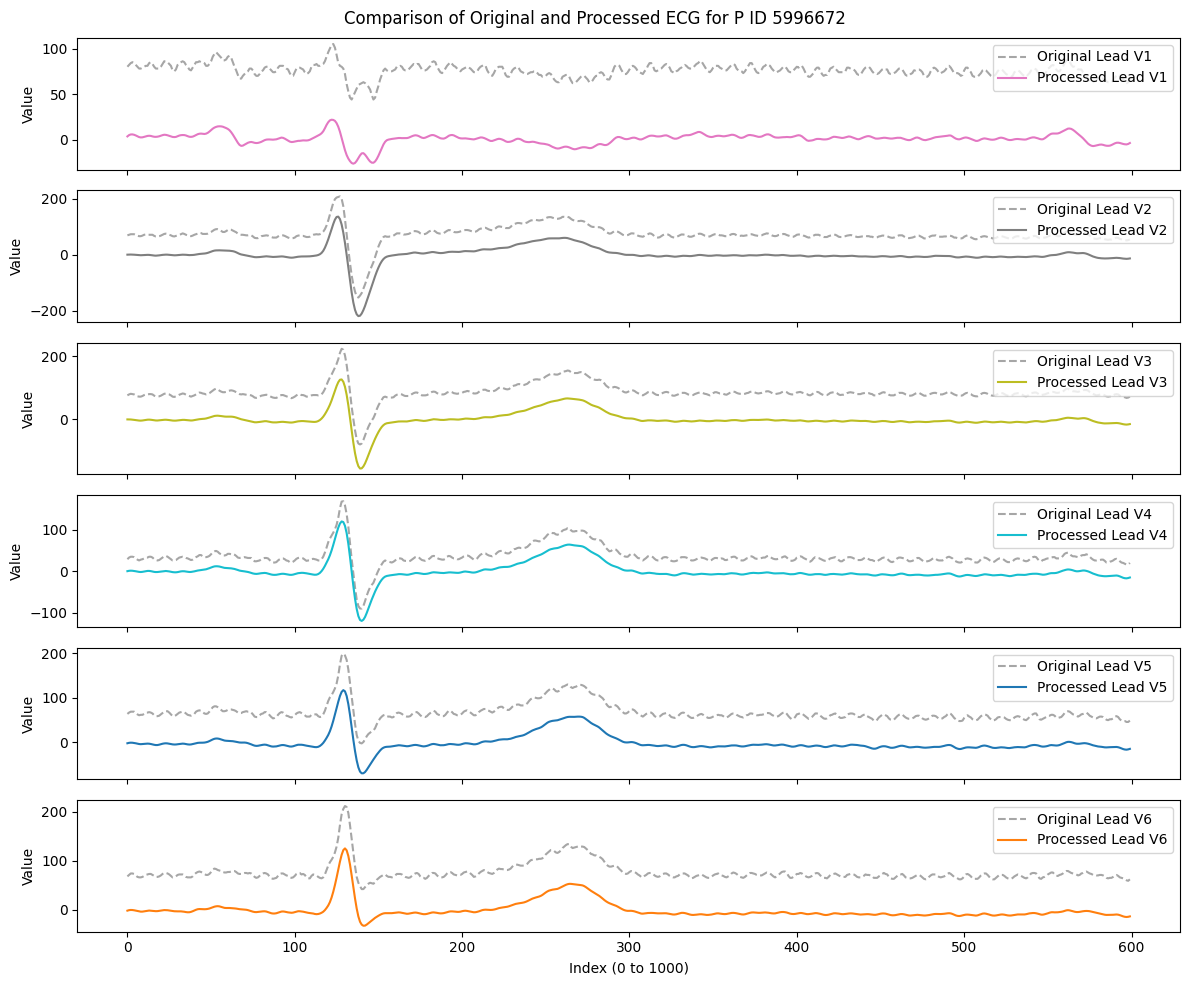

In [8]:
# Extract the original and processed ECG signals
original_tensor = original_main_tensor[tensor_idx, :, :600]  # Assuming you have the original data
processed_tensor = main_tensor[tensor_idx, :, :600]  # Processed ECG

# Create subplots
leads_2_plot = 6
fig, axes = plt.subplots(nrows=leads_2_plot, ncols=1, figsize=(12, 10), sharex=True)

for idx in range(leads_2_plot):
    # Plot original ECG in gray
    i = idx + 6
    axes[idx].plot(original_tensor[i].numpy(), label=f"Original Lead {leads[i]}", color="gray", linestyle="dashed", alpha=0.7)

    # Plot processed ECG in color
    axes[idx].plot(processed_tensor[i].numpy(), label=f"Processed Lead {leads[i]}", color=f"C{i}")

    # Add legend and labels
    axes[idx].legend(loc="upper right")
    axes[idx].set_ylabel("Value")

axes[-1].set_xlabel("Index (0 to 1000)")
fig.suptitle(f"Comparison of Original and Processed ECG for P ID {id_tensor[tensor_idx]}", fontsize=12)

plt.tight_layout()
plt.show()

torch.Size([200, 5000])


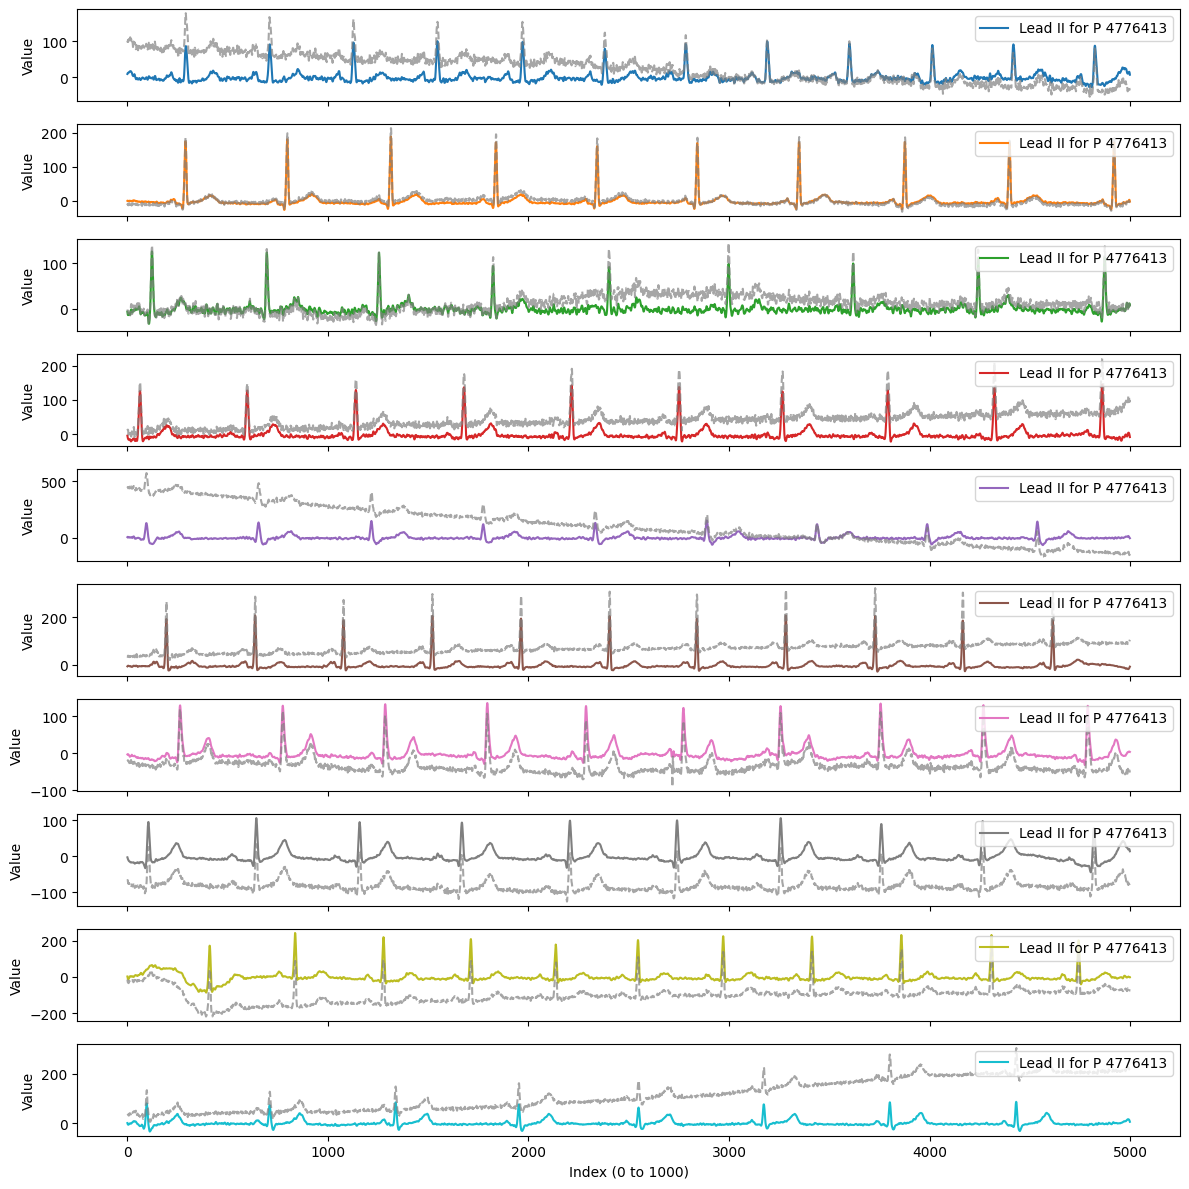

In [12]:
tensor = main_tensor[:,0,:]
original_tensor = original_main_tensor[:, 0, :]  # Assuming you have the original data
print(tensor.shape)

# Create subplots
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(12, 12), sharex=True)

for idx in range(10):
    i = idx + 50
    axes[idx].plot(tensor[i].numpy(), label=f"Lead {'II'} for P {id_tensor[2]}", color="C" + str(i))
    axes[idx].legend(loc="upper right")
    axes[idx].set_ylabel("Value")

    # Plot original ECG in gray
    axes[idx].plot(original_tensor[i].numpy(), color="gray", linestyle="dashed", alpha=0.7)


axes[-1].set_xlabel("Index (0 to 1000)")
# fig.suptitle("Subplots of Tensor Rows", fontsize=14)

plt.tight_layout()
plt.show()

torch.Size([200, 5000])


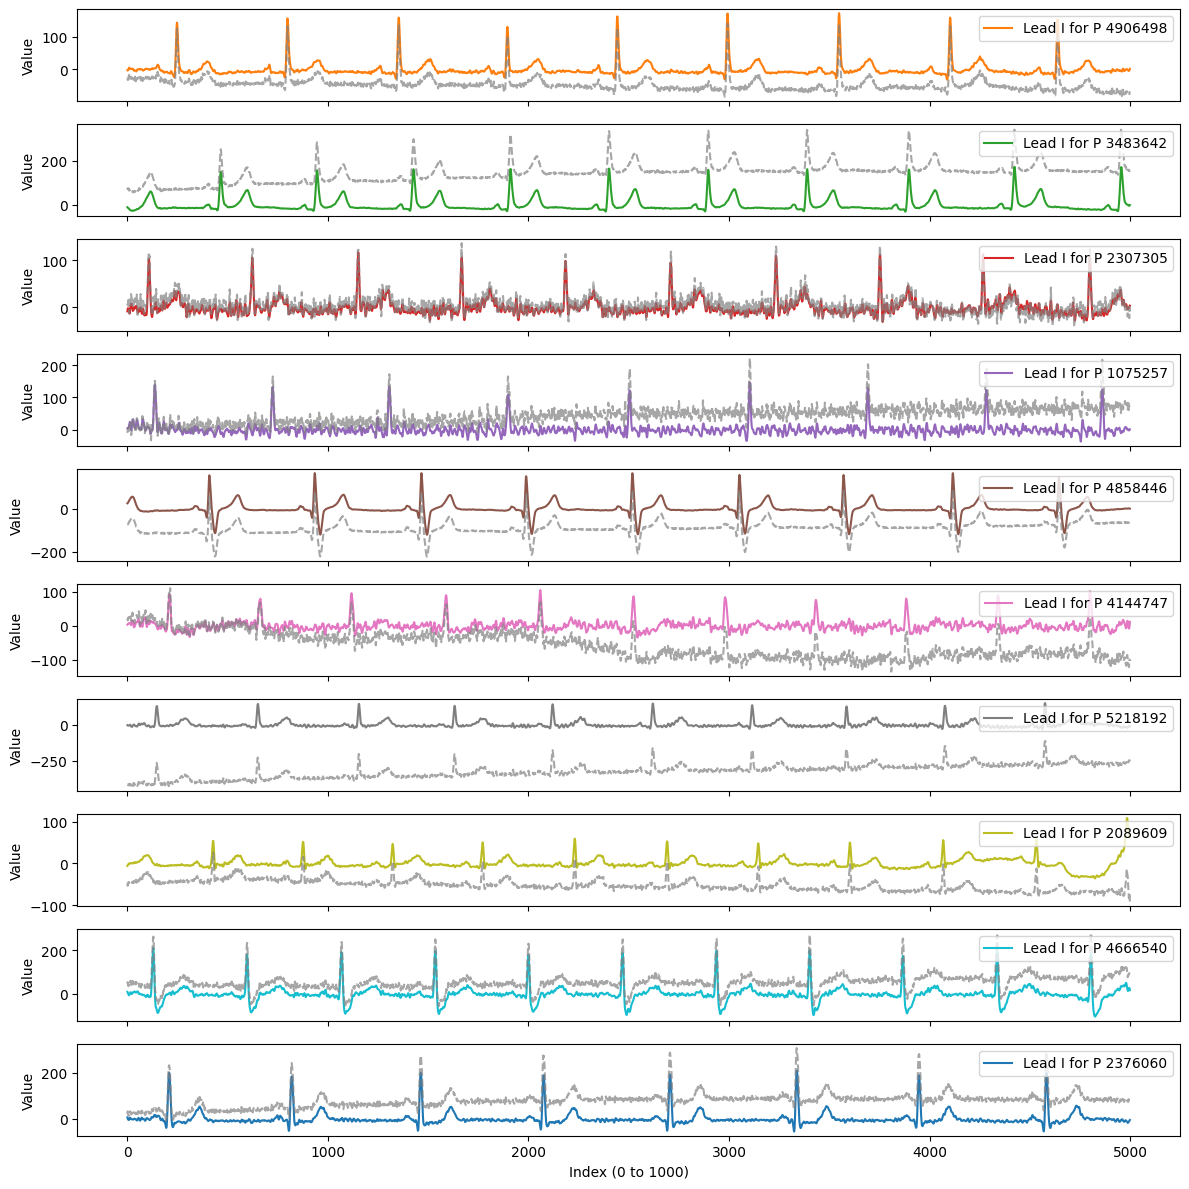

In [13]:
tensor = main_tensor[:,0,:]
original_tensor = original_main_tensor[:, 0, :]  # Assuming you have the original data
print(tensor.shape)

# Create subplots
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(12, 12), sharex=True)

for idx in range(10):
    i = idx + 61
    axes[idx].plot(tensor[i].numpy(), label=f"Lead 'I' for P {id_tensor[i]}", color="C" + str(i))
    axes[idx].legend(loc="upper right")
    axes[idx].set_ylabel("Value")

    # Plot original ECG in gray
    axes[idx].plot(original_tensor[i].numpy(), color="gray", linestyle="dashed", alpha=0.7)


axes[-1].set_xlabel("Index (0 to 1000)")
# fig.suptitle("Subplots of Tensor Rows", fontsize=14)

plt.tight_layout()
plt.show()

torch.Size([200, 5000])


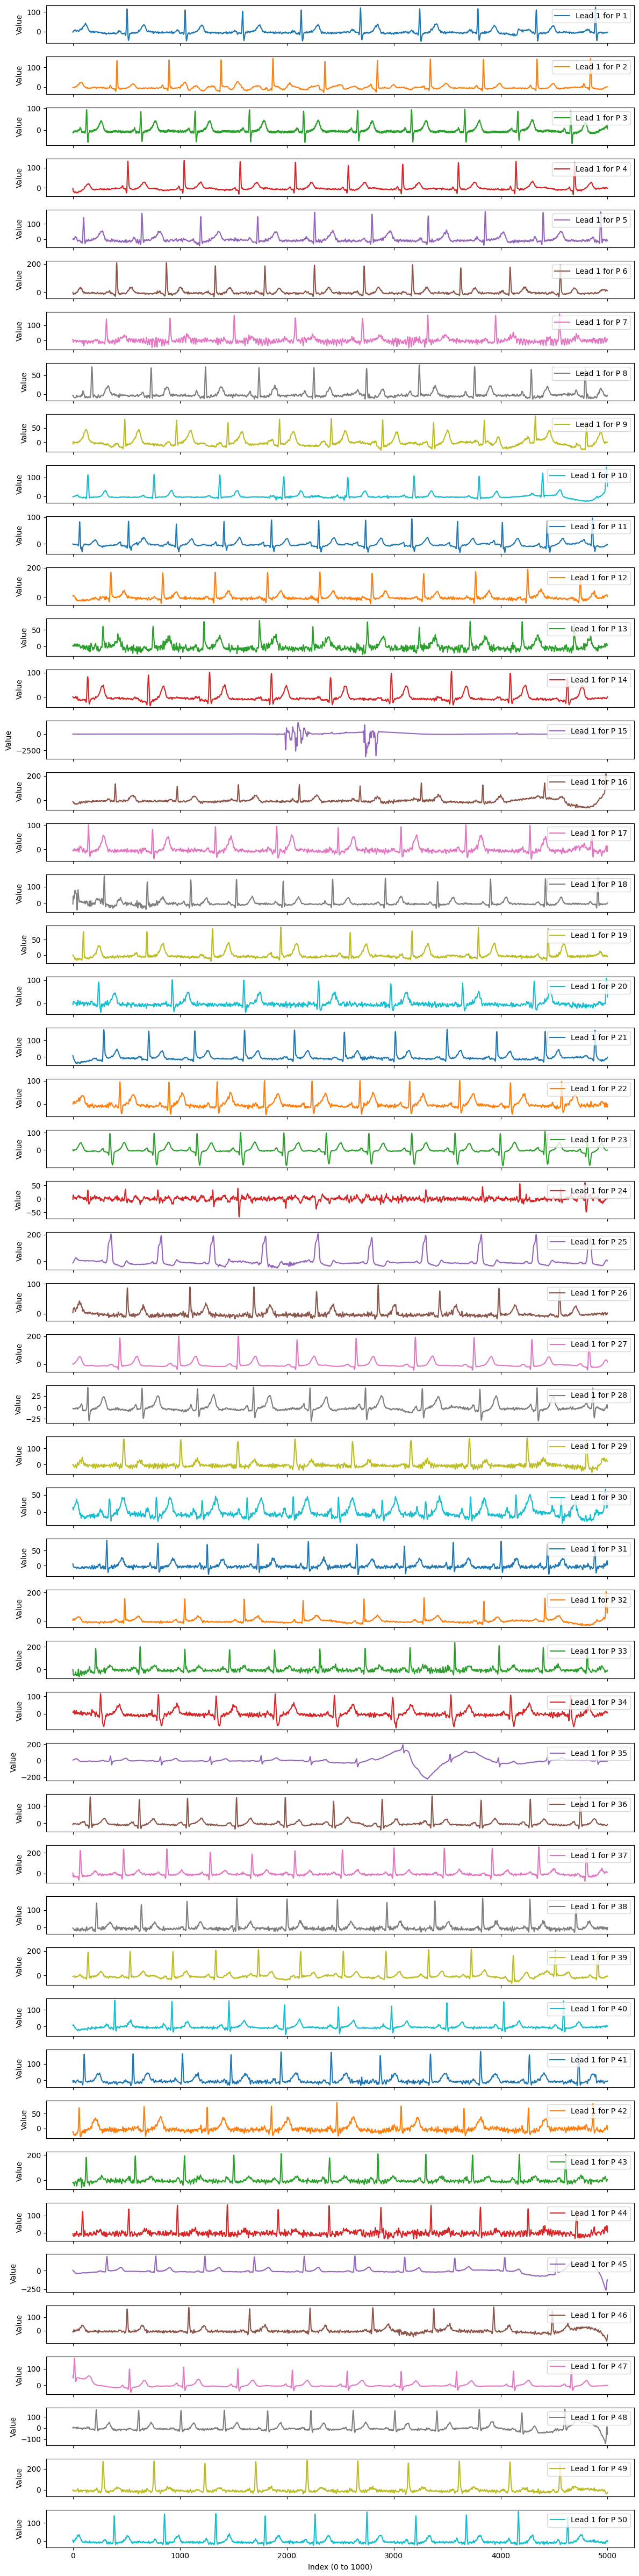

In [22]:
tensor = main_tensor[:,0,:]
print(tensor.shape)

# Create subplots
fig, axes = plt.subplots(nrows=50, ncols=1, figsize=(12, 48), sharex=True)

for i in range(50):
    axes[i].plot(tensor[i].numpy(), label=f"Lead 'I' for P {i+1}", color="C" + str(i))
    axes[i].legend(loc="upper right")
    axes[i].set_ylabel("Value")


axes[-1].set_xlabel("Index (0 to 1000)")
# fig.suptitle("Subplots of Tensor Rows", fontsize=14)

plt.tight_layout()
plt.show()

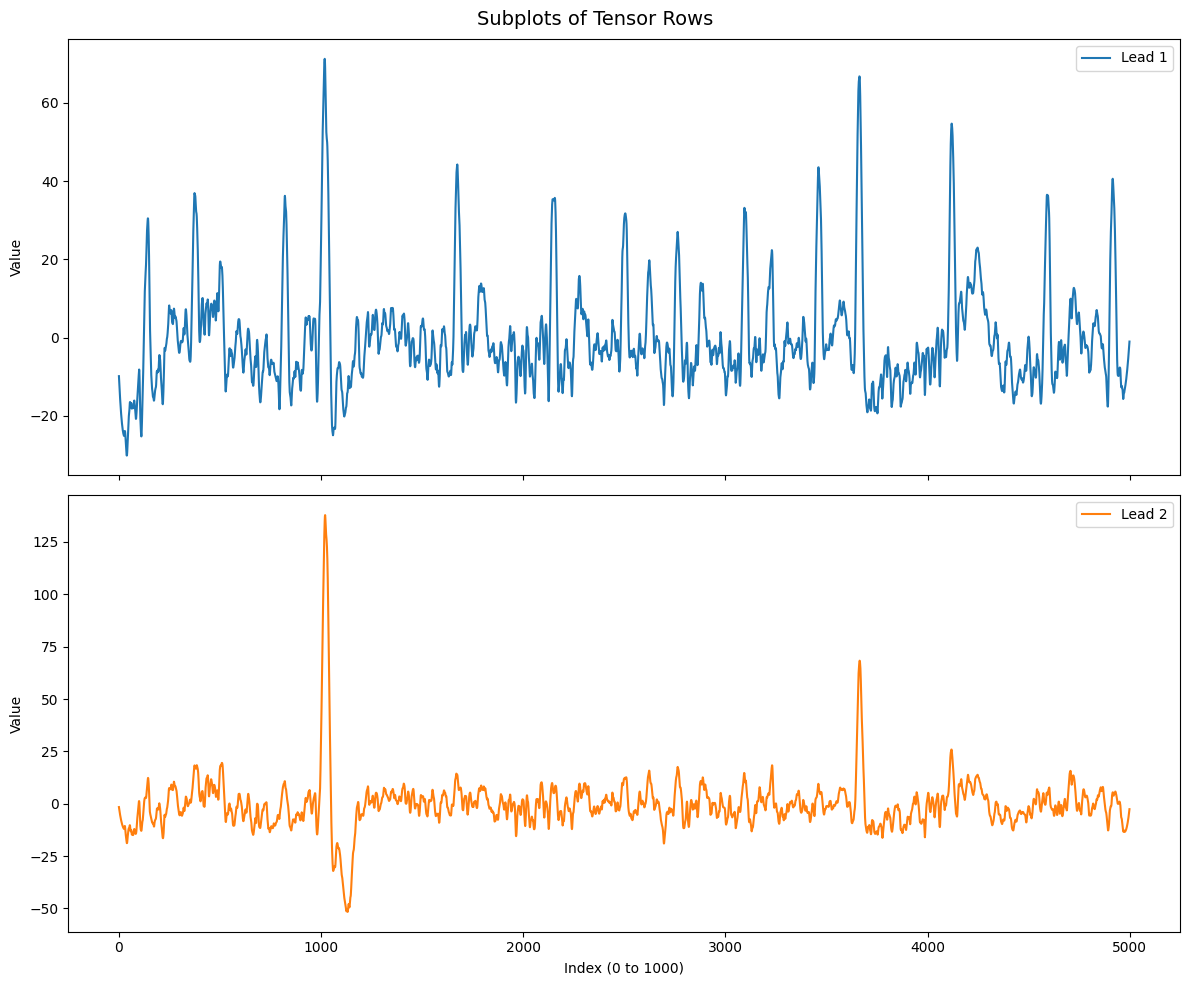

In [5]:
tensor = main_tensor[47,:,:]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

for i in range(2):
    axes[i].plot(tensor[i].numpy(), label=f"Lead {i+1}", color="C" + str(i))
    axes[i].legend(loc="upper right")
    axes[i].set_ylabel("Value")


axes[-1].set_xlabel("Index (0 to 1000)")
fig.suptitle("Subplots of Tensor Rows", fontsize=14)

plt.tight_layout()
plt.show()

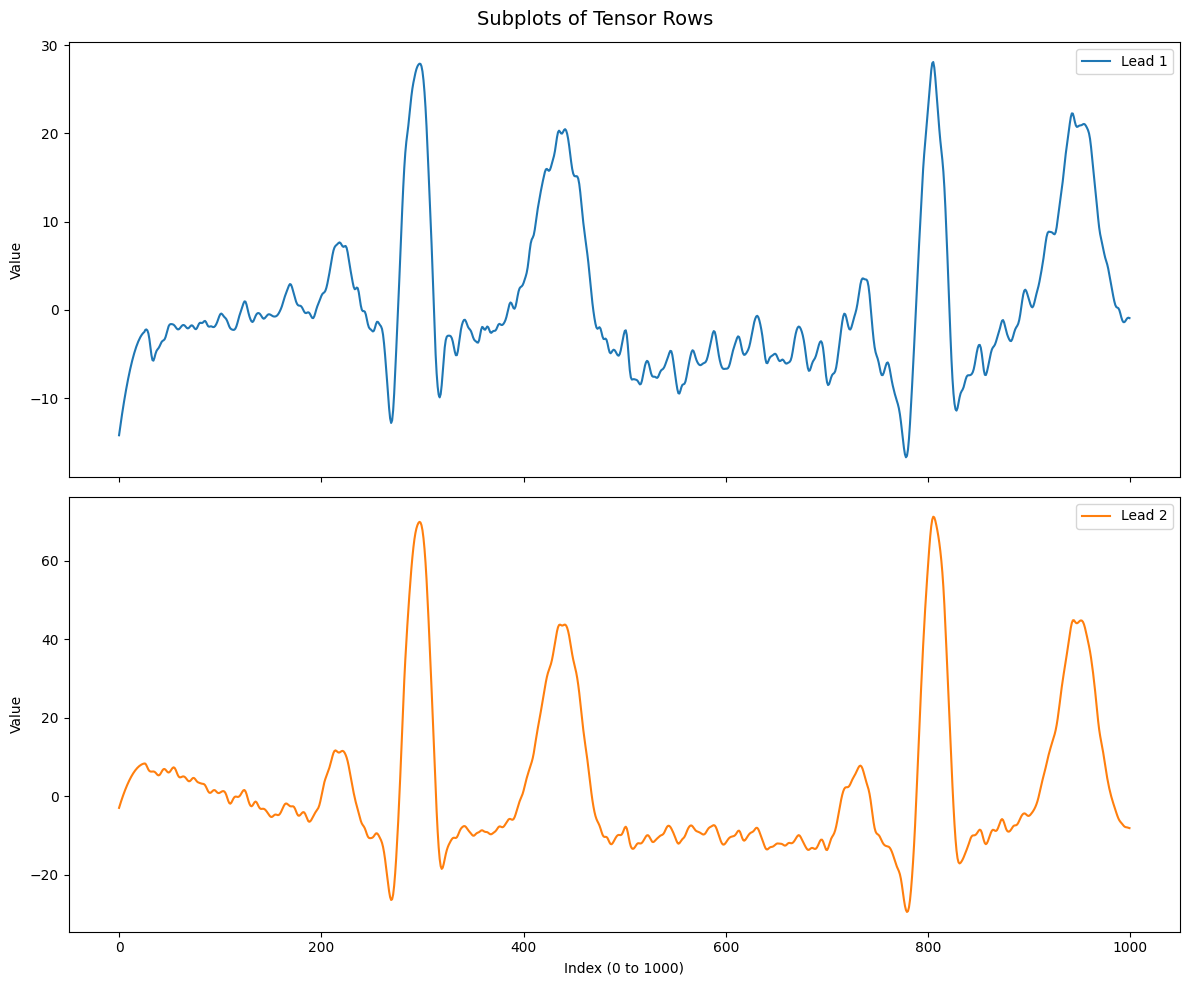

In [6]:
tensor = main_tensor[30,:,:1000]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

for i in range(2):
    axes[i].plot(tensor[i].numpy(), label=f"Lead {i+1}", color="C" + str(i))
    axes[i].legend(loc="upper right")
    axes[i].set_ylabel("Value")


axes[-1].set_xlabel("Index (0 to 1000)")
fig.suptitle("Subplots of Tensor Rows", fontsize=14)

plt.tight_layout()
plt.show()

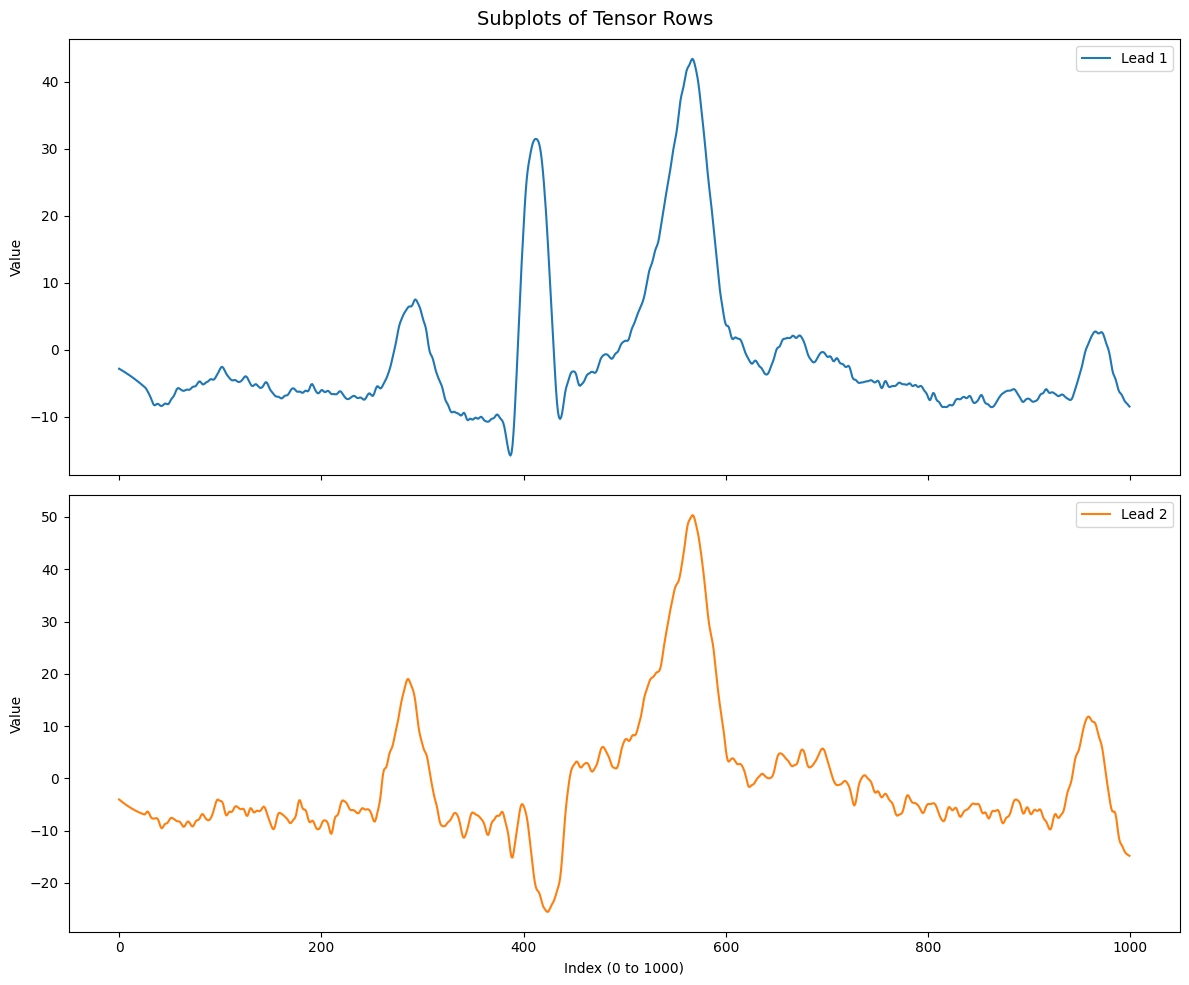

In [7]:
tensor = main_tensor[20,:,:1000]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

for i in range(2):
    axes[i].plot(tensor[i].numpy(), label=f"Lead {i+1}", color="C" + str(i))
    axes[i].legend(loc="upper right")
    axes[i].set_ylabel("Value")


axes[-1].set_xlabel("Index (0 to 1000)")
fig.suptitle("Subplots of Tensor Rows", fontsize=14)

plt.tight_layout()
plt.show()

In [3]:
signal_tensor = main_tensor[:3,:,:].unsqueeze(2)
print(signal_tensor.shape)

with torch.no_grad():
    latent = model_mae(signal_tensor, return_latent=True)
    print(latent.shape)


NameError: name 'main_tensor' is not defined

In [16]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')

#tensor = torch.load(tensor_path)[:3,:,:]
tensor = main_tensor[:3,:,:].unsqueeze(2)
print(tensor.shape)

loss, pred, mask, imgs = model_mae(tensor.float(), mask_ratio=.7, visualize=True)

pred = model_mae.unpatchify(pred)
target = model_mae.patchify(imgs)


print(pred.shape)
print(mask.shape)
print(imgs.shape)
print(target.shape)

MAE with pixel reconstruction:
torch.Size([3, 12, 1, 5000])


torch.Size([3, 1, 12, 5000])
torch.Size([3, 600])
torch.Size([3, 1, 12, 5000])
torch.Size([3, 600, 100])


## Evaluate Reconstructions from MAE

#### Visualize the Reconstruction for the ECG enocders

In [2]:
# chkpt_dir = 'mae_visualize_vit_large.pth'
# chkpt_model = "/home/abujalancegome/deep_risk/mae/pretrain_mae/lr_1e-4_wd_1e-4_mr_0.7/checkpoint-9-loss-0.6338.pth"
chkpt_model = '/home/abujalancegome/deep_risk/mae/MAE_pretrain_chkpts/checkpoint-94-loss-0.1754.pth'
chkpt_model = '/home/abujalancegome/deep_risk/mae/MAE_pretrain/checkpoint-141-loss-0.1758.pth' # best medium
# chkpt_model = '/home/abujalancegome/deep_risk/mae/MAE_pretrain/small/checkpoint-103-loss-0.1965.pth' # best small e.d. = 384
# chkpt_model = '/home/abujalancegome/deep_risk/mae/MAE_pretrain/tiny/checkpoint-136-loss-0.1797.pth' # best tiny e.d. = 192
# model_mae = prepare_model(chkpt_model, 'mae_vit_base_patchX_dec512d8b') # mae_vit_base_patchX_dec512d8b

# model_mae = torch.load(chkpt_model, map_location=torch.device('cpu'))

model_name = 'mae_vit_mediumDeep_patchX' # 'mae_vit_smallDeep_patchX' # 'mae_vit_tinyDeep_patchX' # also mae_vit_smallDeep_patchX, mae_vit_mediumDeep_patchX, mae_vit_base

model_mae = models_mae.__dict__[model_name](
    img_size=(12, 5000),
    patch_size=(1, 100),
    norm_pix_loss=False,
    ncc_weight=0.1
)
print('Model loaded.')

checkpoint = torch.load(chkpt_model, map_location='cpu')
msg = model_mae.load_state_dict(checkpoint['model'], strict=False)
print(msg)


Model loaded.
<All keys matched successfully>


In [3]:
# Plot on test data

tensor_path = "/home/abujalancegome/deep_risk/data/ECG_leads_test.pt"

tensor = torch.load(tensor_path)[:10, :, :, :] # 500
print(tensor.shape)

loss, pred, mask, imgs = model_mae(tensor.float(), mask_ratio=.7, visualize=True)

print("unpatchifying the predictions...")
pred = model_mae.unpatchify(pred)
# target = model_mae.patchify(imgs)

torch.Size([10, 12, 1, 5000])
unpatchifying the predictions...


In [4]:
latent = model_mae(tensor.float(), mask_ratio=.7, return_latent=True)

print(latent.shape)


torch.Size([10, 181, 576])


In [13]:
tensor_path = "/home/abujalancegome/deep_risk/data/ECG_ids_test.pt"

id_tensor = torch.load(tensor_path)[:50] # 500

print(id_tensor[0].item())

4486616


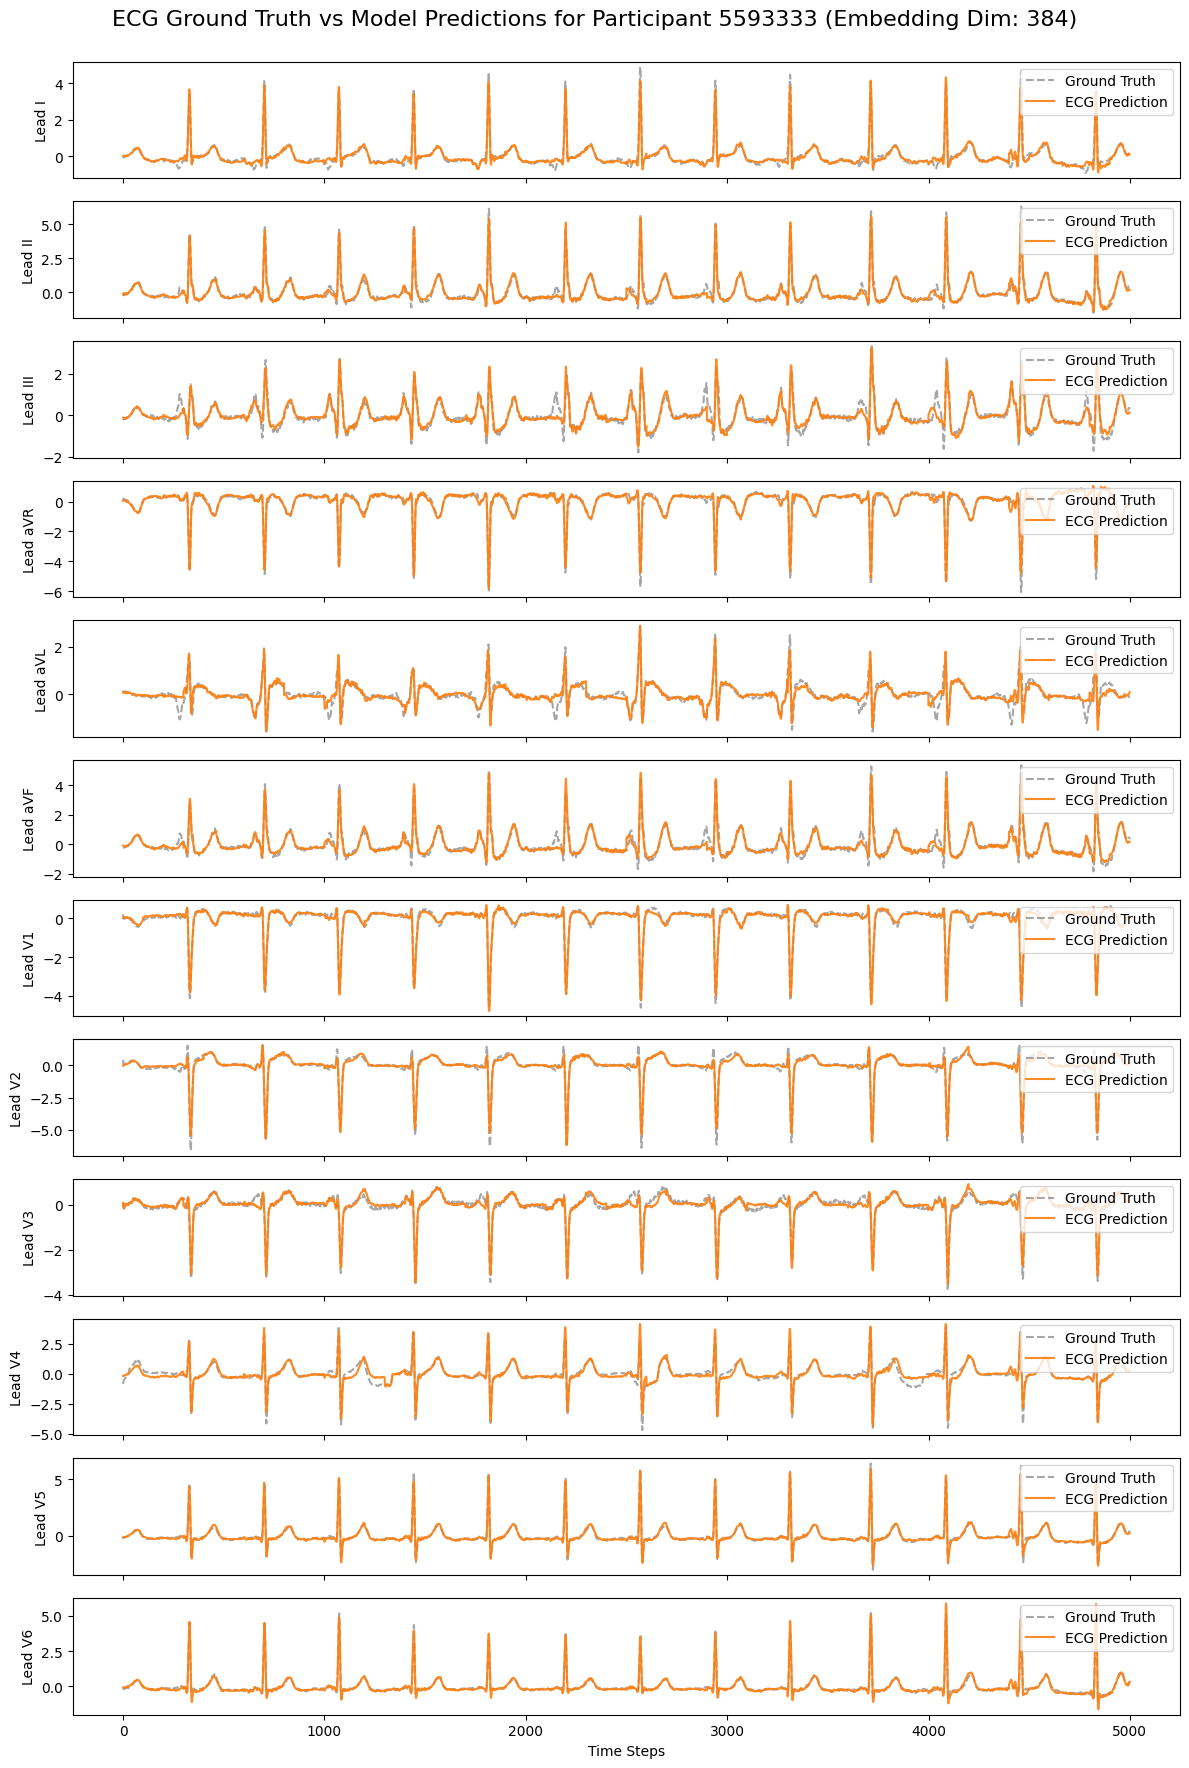

In [14]:
import torch
import matplotlib.pyplot as plt

def plot_ecg_by_participant(ground_truth, predictions, participant_idx, embedding_dim=None, time_steps=5000):
    """
    Plots the 12 ECG channels (leads) for a specific participant.
    
    Parameters:
    - ground_truth: A PyTorch tensor of shape [N, 1, 12, 5000] representing the original ECG.
    - predictions: A PyTorch tensor of shape [N, 1, 12, 5000] representing the model predictions.
    - participant_idx: The index of the participant to plot.
    - embedding_dim: (Optional) A numeric value representing the embedding dimension to be displayed.
    - time_steps: The number of time steps to plot. Default is 5000.
    - id_tensor: (Optional) Tensor/list of participant IDs (for title display).
    - leads: (Optional) List of lead names. Defaults to Lead 0–11.
    """
    if participant_idx >= ground_truth.size(0) or participant_idx >= predictions.size(0):
        raise ValueError("Participant index out of range.")

    if time_steps > ground_truth.size(3) or time_steps > predictions.size(3):
        raise ValueError("time_steps cannot be greater than the number of time steps in the tensors.")
    
    predictions = predictions.detach()
    
    fig, axes = plt.subplots(12, 1, figsize=(12, 18), sharex=True)
    
    participant_id = id_tensor[participant_idx] if id_tensor is not None else participant_idx
    title = f'ECG Ground Truth vs Model Predictions for Participant {participant_id}'
    if embedding_dim is not None:
        title += f' (Embedding Dim: {embedding_dim})'
    
    fig.suptitle(title, fontsize=16)
    
    if leads is None:
        lead_names = [f'Lead {i}' for i in range(12)]
    else:
        lead_names = [f'Lead {leads[i]}' for i in range(12)]
    
    for i in range(12):
        axes[i].plot(ground_truth[participant_idx, 0, i, :time_steps], label='Ground Truth', color="gray", linestyle="dashed", alpha=0.7)
        axes[i].plot(predictions[participant_idx, 0, i, :time_steps], label='ECG Prediction', color='C1', linestyle='-', alpha=0.9)
        
        axes[i].set_ylabel(lead_names[i])
        axes[i].legend(loc='upper right')
        
    axes[-1].set_xlabel('Time Steps')
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit title
    plt.show()

target_participant = 7
# plot_ecg_by_participant(imgs, pred, participant_idx=target_participant, time_steps=5000)
plot_ecg_by_participant(imgs, pred, participant_idx=target_participant, embedding_dim="384", time_steps=5000)

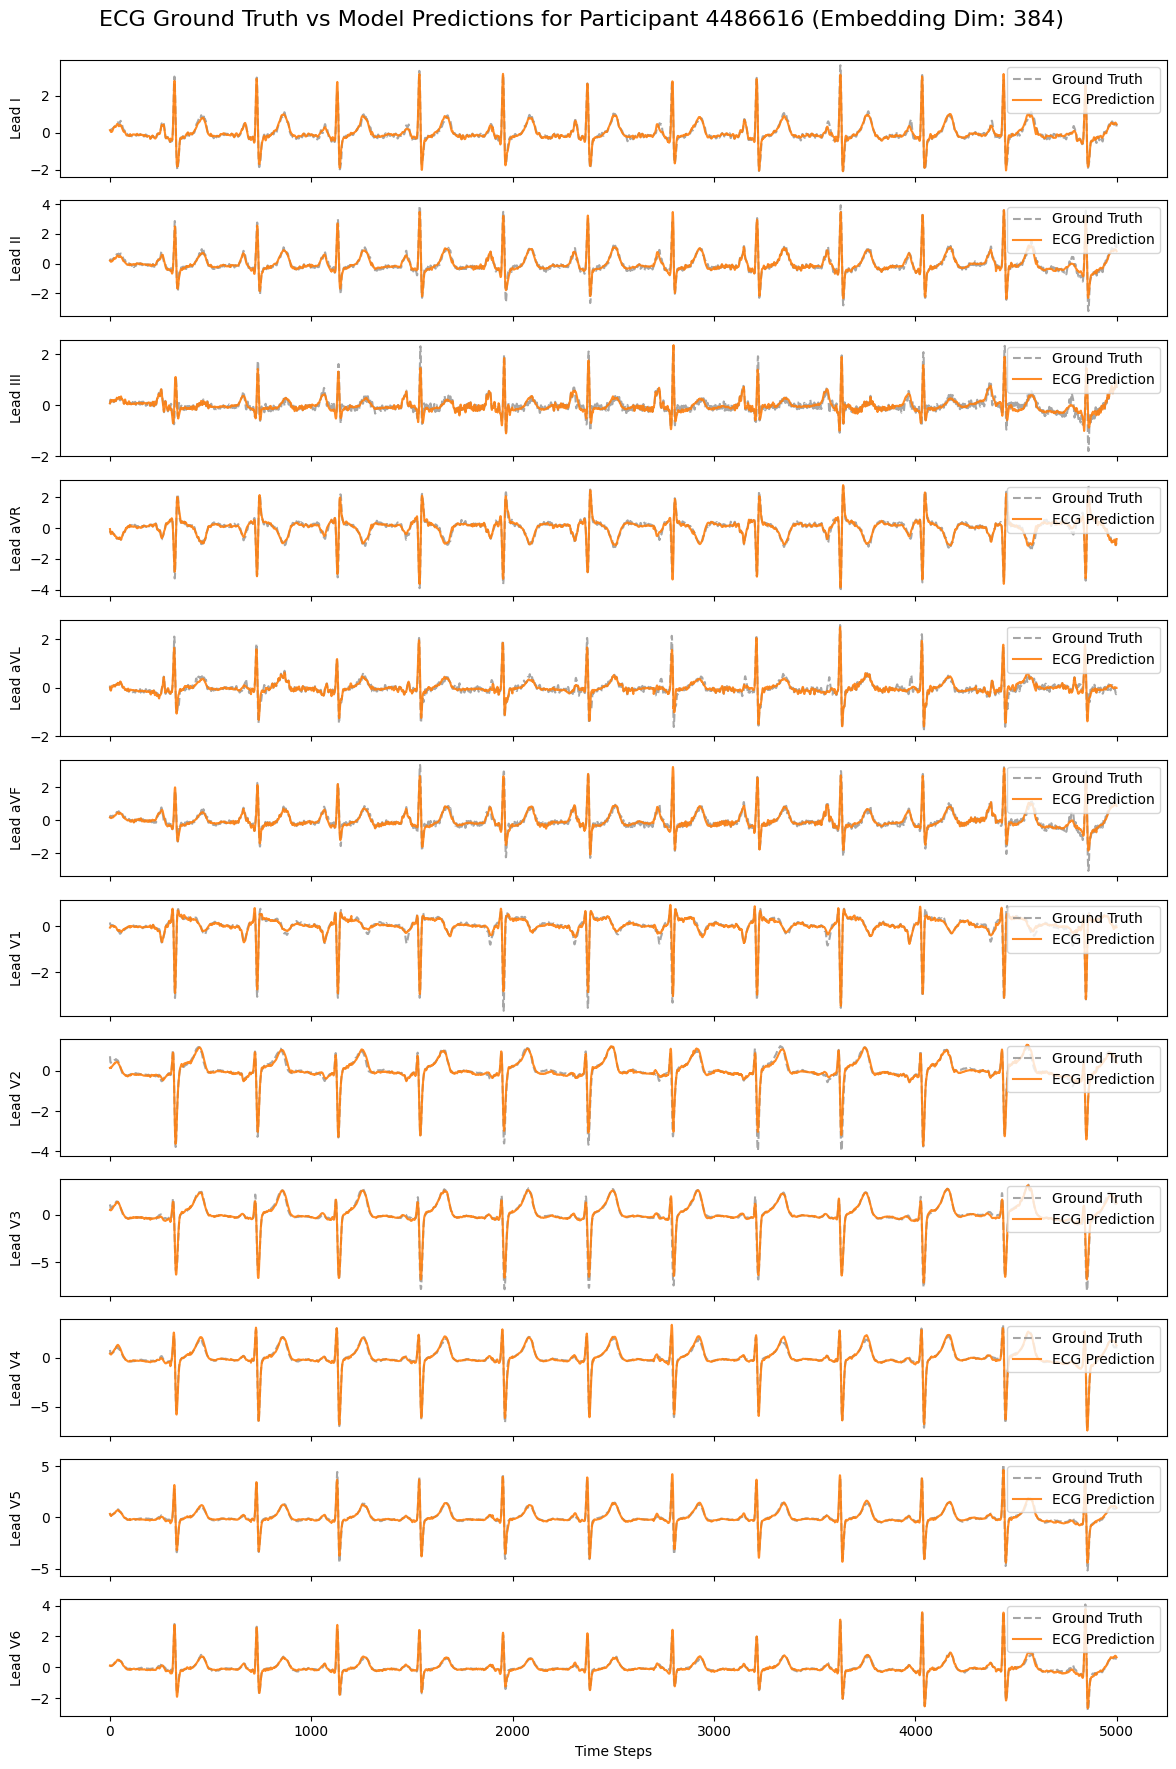

In [15]:
target_participant = 0  # Select participant index (0-based) # prev 17
plot_ecg_by_participant(imgs, pred, participant_idx=target_participant, embedding_dim="384", time_steps=5000)

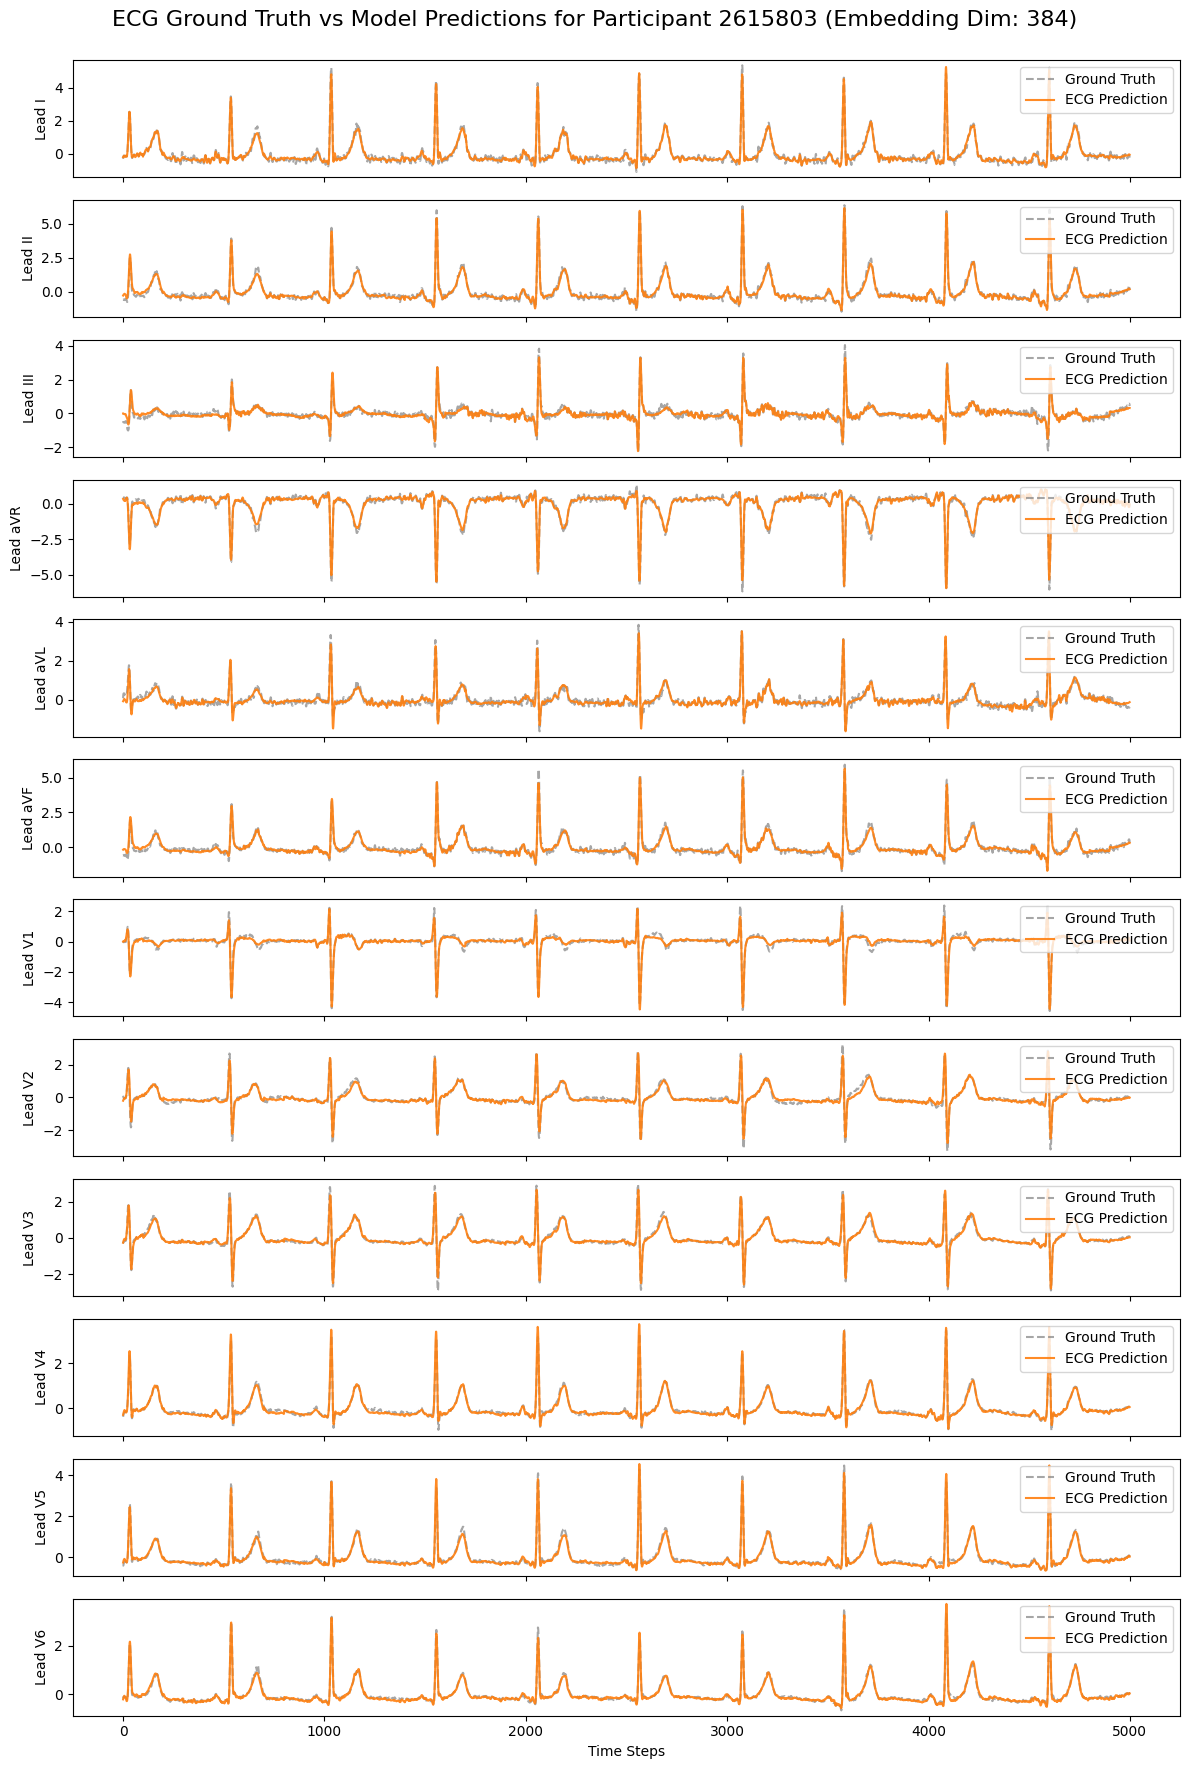

In [16]:
target_participant = 5  # Select participant index (0-based) # prev 17
plot_ecg_by_participant(imgs, pred, participant_idx=target_participant, embedding_dim="384", time_steps=5000)

In [12]:
print(imgs.shape)

torch.Size([10, 1, 12, 5000])


#### Numerical Evaluation

In [17]:
ECG_preds = pred[:,:,:,:].squeeze(1).detach().numpy()
print(ECG_preds.shape)
ECG_imgs = imgs[:,0,:,:].detach().numpy()
print(ECG_imgs.shape)

(50, 12, 5000)
(50, 12, 5000)


In [18]:
# Compute the correlation coefficient
num_leads = 12

coefs = []
for lead in range(num_leads):
    correlation_coefficient = np.corrcoef(ECG_preds[0, lead,:], ECG_imgs[0, lead,:])[0, 1]
    print(f"Cross Correlation Coefficient for lead {leads[lead]}:", np.round(correlation_coefficient,3))
    coefs.append(correlation_coefficient)

print(f"\nCross Correlation Coefficient mean across leads:", np.round( np.mean(coefs) ,3))

Cross Correlation Coefficient for lead I: 0.981
Cross Correlation Coefficient for lead II: 0.98
Cross Correlation Coefficient for lead III: 0.919
Cross Correlation Coefficient for lead aVR: 0.983
Cross Correlation Coefficient for lead aVL: 0.947
Cross Correlation Coefficient for lead aVF: 0.968
Cross Correlation Coefficient for lead V1: 0.978
Cross Correlation Coefficient for lead V2: 0.984
Cross Correlation Coefficient for lead V3: 0.989
Cross Correlation Coefficient for lead V4: 0.989
Cross Correlation Coefficient for lead V5: 0.981
Cross Correlation Coefficient for lead V6: 0.985

Cross Correlation Coefficient mean across leads: 0.974


In [12]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

from sklearn.metrics import mean_squared_error

mse_errors = []
for lead in range(num_leads):
    mse_x_lead = mean_squared_error(ECG_preds[0,lead,:20], ECG_imgs[0,lead,:20])
    mse_errors.append(mse_x_lead)
    
    print(f"MSE for lead {leads[lead]}:", np.round(mse_x_lead,3))

print(f"\nMSE mean across leads:", np.round( np.mean(mse_errors) ,3))

MSE for lead I: 0.002
MSE for lead II: 0.001
MSE for lead III: 0.002
MSE for lead aVR: 0.007
MSE for lead aVL: 0.003
MSE for lead aVF: 0.01
MSE for lead V1: 0.005
MSE for lead V2: 0.003
MSE for lead V3: 0.013
MSE for lead V4: 0.002
MSE for lead V5: 0.002
MSE for lead V6: 0.003

MSE mean across leads: 0.005


In [60]:
results = {f"lead {lead + 1}": [] for lead in range(num_leads)}
correlations = {f"lead {lead + 1}": [] for lead in range(num_leads)}

num_ecg = ECG_imgs.shape[0]

for n in range(num_ecg):
    if n == 4 or n==47:
        continue

    for lead in range(num_leads):
        mse_x_lead = mse(ECG_imgs[n,lead,:], ECG_preds[n,lead,:])

        if mse_x_lead > 0.2:
            print(f"MSE large lead value in lead {lead + 1} for ID {n}: {mse_x_lead}")
        correlation_coefficient = np.corrcoef(ECG_preds[n, lead,:], ECG_imgs[n, lead,:])[0, 1]

        results[f"lead {lead + 1}"].append(mse_x_lead)
        correlations[f"lead {lead + 1}"].append(correlation_coefficient)

mse_results = {key: {"mean": np.round(np.mean(values), 3), "std": np.round(np.std(values, ddof=1), 3)} for key, values in results.items()}
corr_results = {key: {"mean": np.round(np.mean(values), 3), "std": np.round(np.std(values, ddof=1), 3)} for key, values in correlations.items()}

print(mse_results)
print(corr_results)

MSE large lead value in lead 10 for ID 17: 0.795652449131012
MSE large lead value in lead 10 for ID 54: 0.38150307536125183
MSE large lead value in lead 8 for ID 63: 0.2624242305755615
{'lead 1': {'mean': 0.007, 'std': 0.011}, 'lead 2': {'mean': 0.005, 'std': 0.006}, 'lead 3': {'mean': 0.004, 'std': 0.004}, 'lead 4': {'mean': 0.007, 'std': 0.01}, 'lead 5': {'mean': 0.005, 'std': 0.007}, 'lead 6': {'mean': 0.004, 'std': 0.004}, 'lead 7': {'mean': 0.007, 'std': 0.006}, 'lead 8': {'mean': 0.012, 'std': 0.029}, 'lead 9': {'mean': 0.008, 'std': 0.007}, 'lead 10': {'mean': 0.02, 'std': 0.088}, 'lead 11': {'mean': 0.007, 'std': 0.009}, 'lead 12': {'mean': 0.005, 'std': 0.006}}
{'lead 1': {'mean': 0.954, 'std': 0.047}, 'lead 2': {'mean': 0.963, 'std': 0.036}, 'lead 3': {'mean': 0.95, 'std': 0.046}, 'lead 4': {'mean': 0.961, 'std': 0.034}, 'lead 5': {'mean': 0.944, 'std': 0.06}, 'lead 6': {'mean': 0.952, 'std': 0.049}, 'lead 7': {'mean': 0.957, 'std': 0.041}, 'lead 8': {'mean': 0.953, 'std': 0.

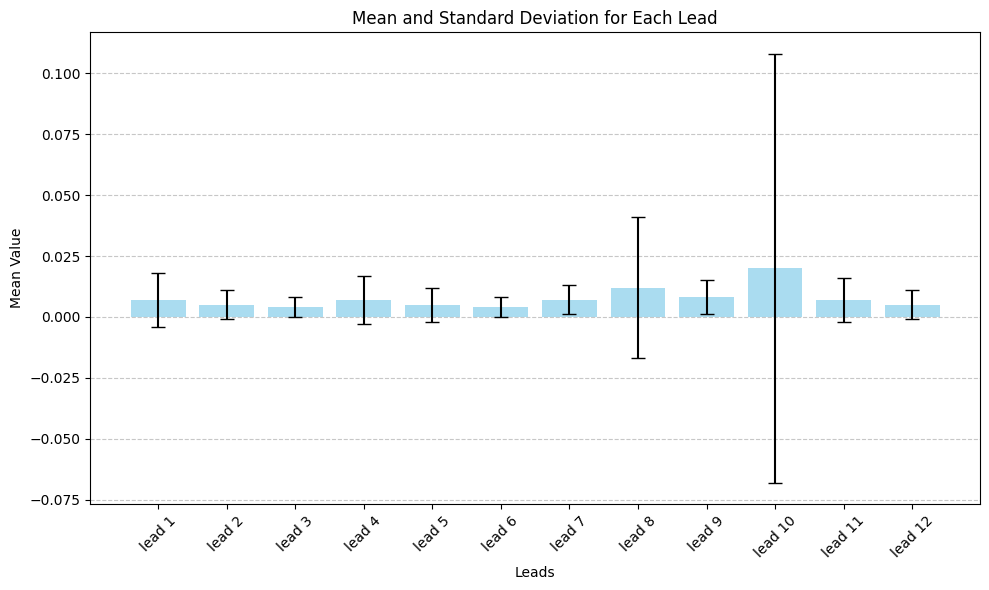

In [56]:
def plot_lead_results(results):
    leads = list(results.keys())
    means = [results[lead]['mean'] for lead in leads]
    stds = [results[lead]['std'] for lead in leads]

    plt.figure(figsize=(10, 6))
    plt.bar(leads, means, yerr=stds, capsize=5, color='skyblue', alpha=0.7)
    plt.xlabel('Leads')
    plt.ylabel('Mean Value')
    plt.title('Mean and Standard Deviation for Each Lead')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_lead_results(mse_results)

In [37]:
import pandas as pd
import os


# Get the directory of the current Python file
initial_file_dir = os.path.dirname(os.path.abspath("/home/abujalancegome/dataloader.py"))

# Get the parent directory
parent_dir = os.path.dirname(os.path.dirname(initial_file_dir))

# Change the working directory to the parent directory
os.chdir("/gpfs")
print("parent_dir", initial_file_dir)

pheno_data = pd.read_csv('work2/0/aus20644/data/ukbiobank/phenotypes/ukb678882.tab.gz',
                       sep='\t', compression='gzip', nrows=1, )

pheno_data.head()

parent_dir /home/abujalancegome


f.eid  f.3.0.0  f.3.1.0  f.3.2.0  f.3.3.0  f.4.0.0  f.4.1.0  f.4.2.0  \
0  1000015      269      NaN      NaN      NaN      445      NaN      NaN   

   f.4.3.0  f.5.0.0  ...  f.132596.0.0  f.132597.0.0  f.132598.0.0  \
0      NaN      280  ...           NaN           NaN           NaN   

   f.132599.0.0  f.132600.0.0  f.132601.0.0  f.132602.0.0  f.132603.0.0  \
0           NaN           NaN           NaN           NaN           NaN   

   f.132604.0.0  f.132605.0.0  
0           NaN           NaN  

[1 rows x 32123 columns]

In [39]:
import re
[m for m in pheno_data.columns if re.search('f.20205', m)]

['f.20205.2.0', 'f.20205.3.0']

In [44]:
pheno_data = pd.read_csv('work2/0/aus20644/data/ukbiobank/phenotypes/ukb678882.tab.gz',
                       sep='\t', compression='gzip', nrows=5, )

pheno_data['f.20205.2.0'][3]

'20205_2_0'